Neural Network Anomaly Detection Teaching Notebook
-------------------------------------------------
This notebook will include:
1. Intro to Neural Networks (diagrams + explanation)
2. Data preparation (JSON -> DataFrame -> labels via Isolation Forest)
3. Model 1: MLP Classifier (Supervised)
4. Model 2: Autoencoder (Unsupervised)
5. Visualization & Comparison

-------------------------------
Part 1: Intro to Neural Networks
In this section, students learn what a neuron is, how inputs are processed,
and the concept of layers in a neural network.

In [1]:
# %pip install tensorflow keras

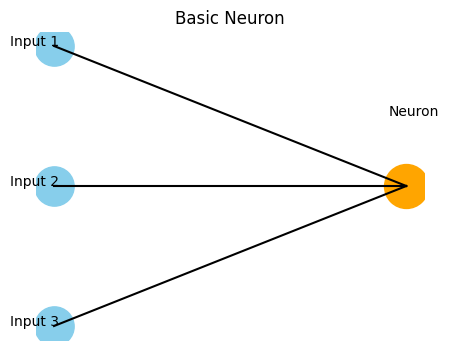

In [1]:
import matplotlib.pyplot as plt
# Draw a simple neuron diagram
plt.figure(figsize=(5,4))
plt.scatter([0.1, 0.1, 0.1], [0.2, 0.5, 0.8], s=800, color='skyblue')
plt.scatter([0.5], [0.5], s=1000, color='orange')
for y in [0.2, 0.5, 0.8]:
    plt.plot([0.1, 0.5], [y, 0.5], 'k')
plt.text(0.05, 0.8, 'Input 1', fontsize=10)
plt.text(0.05, 0.5, 'Input 2', fontsize=10)
plt.text(0.05, 0.2, 'Input 3', fontsize=10)
plt.text(0.48, 0.65, 'Neuron', fontsize=10)
plt.axis('off')
plt.title("Basic Neuron")
plt.show()

This diagram shows a single neuron receiving 3 inputs. Each input has a weight, and the neuron applies an activation function to produce an output.

-------------------------------
Part 2: Data Preparation
Here, we load the JSON metrics data, create pseudo-labels for anomalies using Isolation Forest,
scale the features, and split the dataset into training and test sets.

In [ ]:
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping

import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt

# dataset 1 - 500 observations from psutils
# with open("../datasets/system_metrics.json", "r") as f:
#     data = json.load(f)

# df = pd.DataFrame(data)
# X = df[["cpu", "ram", "net_sent", "net_recv"]]

# dataset 2 - ec2 cpu utilization
df = pd.read_csv("../datasets/ec2_cpu_utilization_5f5533.csv")
X = df[["value"]]

# Create pseudo-labels using Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred = iso.fit_predict(X)
y = np.where(y_pred == -1, 1, 0)  # 1 = anomaly, 0 = normal

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [36]:
y.counts()

AttributeError: 'numpy.ndarray' object has no attribute 'counts'

In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [34]:
X_train

array([[-0.50019896],
       [-0.7609454 ],
       [ 0.34525162],
       ...,
       [ 1.57368806],
       [-1.03284677],
       [-0.91943834]], shape=(3225, 1))

-------------------------------
Part 3: MLP Classifier (Supervised)
In this section, students build a simple feed-forward neural network (MLP) to classify
data points as normal or anomalous. They will learn about layers, activation functions,
and loss functions for binary classification.

MLP Test Accuracy: 0.991


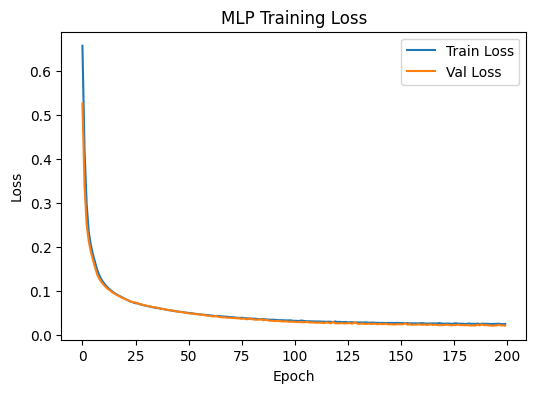

In [35]:
mlp_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = mlp_model.fit(X_train, y_train, validation_split=0.2, epochs=200, verbose=0)

loss, acc = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"MLP Test Accuracy: {acc:.3f}")

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('MLP Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Draw MLP structure diagram

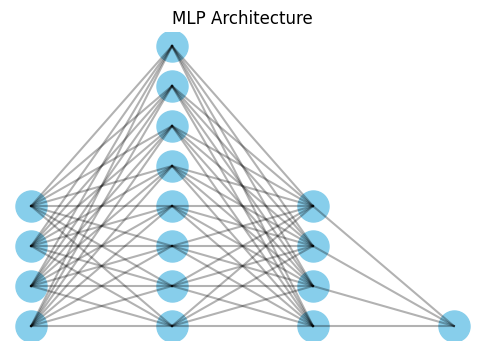

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
layer_sizes = [4, 8, 4, 1]
x_positions = [0, 1, 2, 3]
for i, size in enumerate(layer_sizes):
    for j in range(size):
        ax.scatter([x_positions[i]], [j], s=500, color='skyblue')
    if i > 0:
        for j in range(layer_sizes[i-1]):
            for k in range(layer_sizes[i]):
                ax.plot([x_positions[i-1], x_positions[i]], [j, k], 'k', alpha=0.3)
ax.axis('off')
ax.set_title("MLP Architecture")
plt.show()

This diagram shows a simple MLP with an input layer (4 neurons), two hidden layers, and one output neuron.

-------------------------------
Part 4: Autoencoder (Unsupervised)
This section introduces students to autoencoders, a type of neural network that learns to
reconstruct its input. We train the autoencoder on normal data and use reconstruction error
to detect anomalies.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Autoencoder detected 5 anomalies out of 500


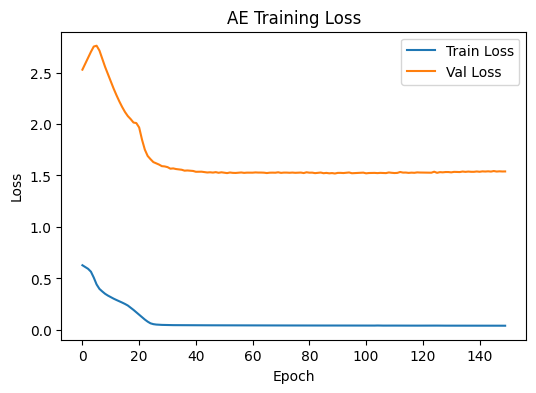

In [25]:

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history_ae = autoencoder.fit(X_train, X_train, epochs=150, batch_size=16, shuffle=True, validation_split=0.2, verbose=0)

# Reconstruction error
y_pred_ae = autoencoder.predict(X_test)
recon_error = np.mean(np.square(X_test - y_pred_ae), axis=1)

# threshold = np.mean(recon_error) + 2*np.std(recon_error)
threshold = np.percentile(recon_error, 99)  # Set threshold at 99.5th percentile
y_pred_labels = (recon_error > threshold).astype(int)

print(f"Autoencoder detected {sum(y_pred_labels)} anomalies out of {len(y_pred_labels)}")

plt.figure(figsize=(6,4))
plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Val Loss')
plt.title('AE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Draw Autoencoder diagram

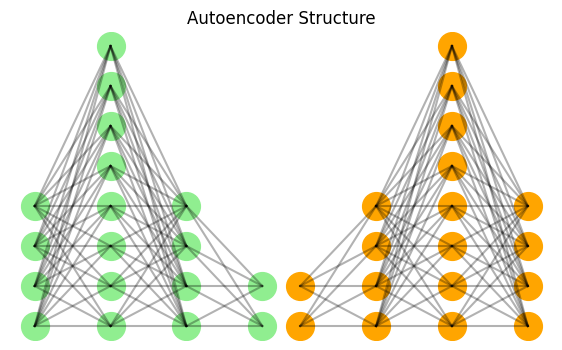

In [26]:
fig, ax = plt.subplots(figsize=(7,4))
encoder_layers = [4, 8, 4, 2]
decoder_layers = [2, 4, 8, 4]
x_positions_enc = [0, 1, 2, 3]
x_positions_dec = [3.5, 4.5, 5.5, 6.5]

for i, size in enumerate(encoder_layers):
    for j in range(size):
        ax.scatter([x_positions_enc[i]], [j], s=400, color='lightgreen')
    if i > 0:
      for j in range(encoder_layers[i-1]):
          for k in range(encoder_layers[i]):
              ax.plot([x_positions_enc[i-1], x_positions_enc[i]], [j, k], 'k', alpha=0.3)

for i, size in enumerate(decoder_layers):
    for j in range(size):
        ax.scatter([x_positions_dec[i]], [j], s=400, color='orange')
    if i > 0:
      for j in range(decoder_layers[i-1]):
          for k in range(decoder_layers[i]):
              ax.plot([x_positions_dec[i-1], x_positions_dec[i]], [j, k], 'k', alpha=0.3)

ax.set_title("Autoencoder Structure")
ax.axis('off')
plt.show()

This diagram shows how an autoencoder compresses input into a smaller representation (encoder) and then reconstructs it back (decoder).

-------------------------------
Part 5: Visualization & Comparison
In this final section, we visualize the training performance of the MLP and
the reconstruction error distribution for the autoencoder. Students can see
how loss changes over epochs and how anomalies are separated based on error.

This plot shows how the training and validation loss change over epochs for the MLP classifier.

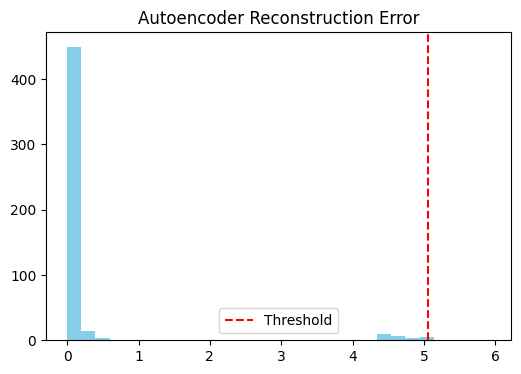

In [27]:
plt.figure(figsize=(6,4))
plt.hist(recon_error, bins=30, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Autoencoder Reconstruction Error')
plt.legend()
plt.show()

This histogram shows the reconstruction error of the autoencoder on test data. Points to the right of the red line are classified as anomalies.

-------------------------------
Final Summary
The MLP model is a supervised approach that requires labeled data. It works well when
we have enough labeled examples of normal and anomalous points.
The Autoencoder is an unsupervised approach. It learns to reconstruct normal data and
flags points with high reconstruction error as anomalies.
Use MLP when labels are available and the dataset is large enough. Use Autoencoder
when labels are scarce or unavailable, and we want to detect outliers based on patterns
in the data.

In [11]:
# Use the trained autoencoder to predict reconstruction error for the entire X DataFrame
X_pred_ae = autoencoder.predict(X_scaled)
recon_error_all = np.mean(np.square(X_scaled - X_pred_ae), axis=1)

X_AE = X.copy()
# Apply the threshold to classify anomalies
X_AE['anomaly_ae'] = (recon_error_all > threshold).astype(int)

X_AE

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,cpu,ram,net_sent,net_recv,anomaly_ae
0,12.6,78.4,63.401973,876.555230,0
1,11.2,78.4,63.478015,876.567491,0
2,10.3,78.4,63.563416,876.589496,0
3,11.1,78.8,63.639262,876.600947,0
4,14.5,79.0,63.729137,876.615638,0
...,...,...,...,...,...
495,12.9,85.3,121.773097,1065.243807,1
496,13.5,85.1,121.880112,1065.282935,1
497,24.6,85.3,122.108528,1065.325688,0
498,25.6,85.4,122.290592,1065.394284,0


In [12]:
X_AE.describe()

,cpu,ram,net_sent,net_recv,anomaly_ae
count,500.00000,500.000000,500.000000,500.000000,500.000000
mean,16.20980,82.471800,90.926576,892.563261,0.056000
std,5.92014,3.497733,16.479933,44.437813,0.230152
min,9.80000,75.800000,63.401973,876.555230,0.000000
25%,12.20000,79.800000,77.077511,878.897276,0.000000
50%,14.20000,81.200000,89.987561,881.003050,0.000000
75%,18.60000,86.300000,104.544653,883.146357,0.000000
max,46.60000,88.300000,122.423190,1065.445098,1.000000


In [13]:
cat_1 = "normal"
cat_2 = "anomaly"
name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
X_AE["anomaly_ae"] = X_AE["anomaly_ae"].apply(name_categories)
X_AE.head()
print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
print(X_AE.loc[X_AE["anomaly_ae"] == cat_1].describe())
print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
print(X_AE.loc[X_AE["anomaly_ae"] == cat_2].describe())

-------------------normal--------------------
              cpu         ram    net_sent     net_recv
count  472.000000  472.000000  472.000000   472.000000
mean    15.621186   82.379449   90.040616   888.541224
std      4.625065    3.525380   16.024029    36.234063
min      9.800000   75.800000   63.401973   876.555230
25%     12.200000   79.700000   76.649122   878.813870
50%     14.200000   81.150000   89.147703   880.684430
75%     18.300000   86.325000  103.781815   882.972139
max     44.000000   88.300000  122.423190  1065.445098
-------------------anomaly-------------------
             cpu        ram    net_sent     net_recv
count  28.000000  28.000000   28.000000    28.000000
mean   26.132143  84.028571  105.861345   960.363319
std    12.900619   2.576368   17.179079    92.427827
min    10.700000  79.700000   68.890470   877.337016
25%    12.750000  81.875000   96.992588   882.079894
50%    29.100000  84.800000  112.051286   885.036109
75%    36.650000  85.450000  120.982084  1

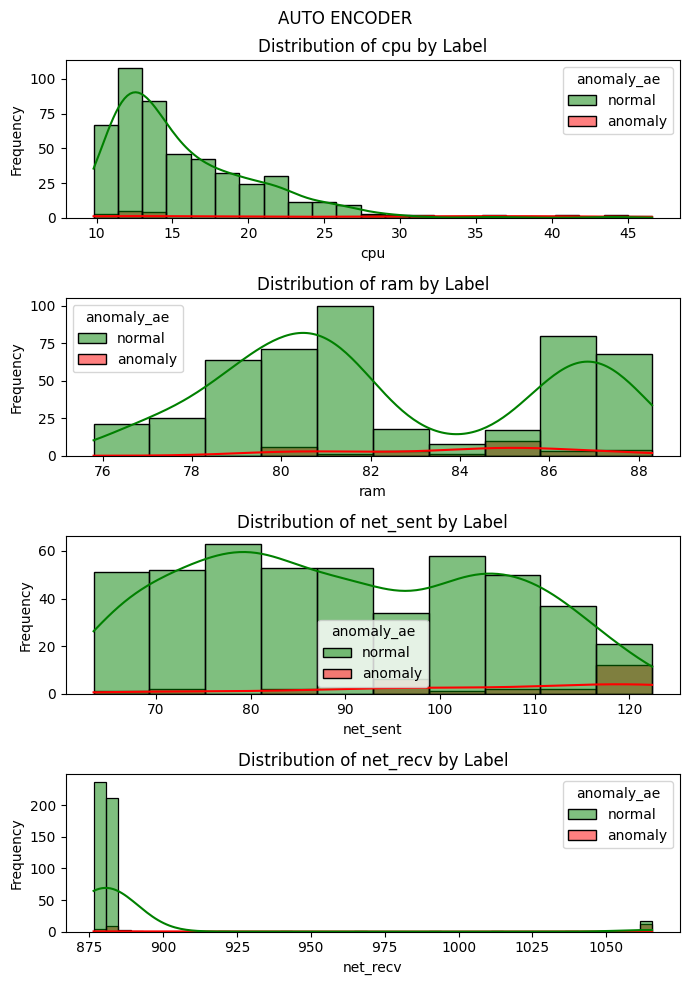

In [14]:
numerical_cols = X_AE.select_dtypes(include=np.number).columns
plt.figure(figsize=(7, 10))
for i, col in enumerate(numerical_cols):
  plt.subplot(len(numerical_cols), 1, i + 1)
  sns.histplot(data=X_AE, x=col, hue='anomaly_ae', palette={'anomaly': 'red', 'normal': 'green'}, kde=True) # Use hue for coloring by label and palette to set specific colors
  plt.title(f'Distribution of {col} by Label')
  plt.tight_layout()
  plt.xlabel(col)
  plt.suptitle("AUTO ENCODER")
  plt.ylabel('Frequency' if df[col].dtype != 'object' else 'Count')

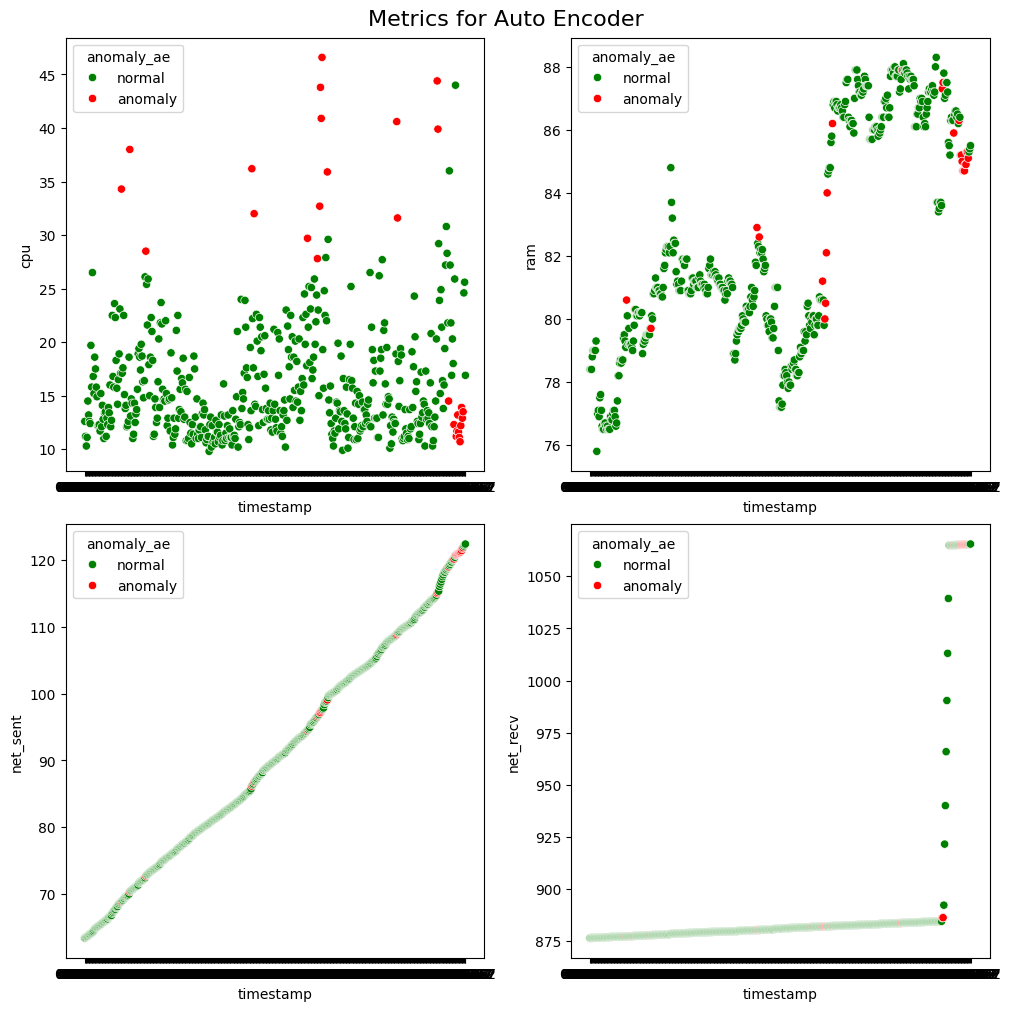

In [15]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig) # Define a 2x2 grid for the current figure
fig.suptitle('Metrics for Auto Encoder', fontsize=16)
ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (2)]
for ax, metric in zip(ax_list, X.columns):
    sns.scatterplot(x=df["timestamp"], y=df[metric], hue=X_AE["anomaly_ae"], palette={'anomaly': 'red', 'normal': 'green'}, data=df, ax=ax)
plt.show()

In [16]:
#use MLP model to predict anomalies on the entire dataset
X_MLP = X.copy()
X_MLP['anomaly_mlp'] = mlp_model.predict(X_scaled).flatten()
X_MLP['anomaly_mlp'] = (X_MLP['anomaly_mlp'] > 0.5).astype(int)
# Convert numerical labels to categorical for better readability
cat_1 = "normal"
cat_2 = "anomaly"
name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
X_MLP["anomaly_mlp"] = X_MLP["anomaly_mlp"].apply(name_categories)
X_MLP.head()
# Display the first few rows of the MLP predictions
print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
print(X_MLP.loc[X_MLP["anomaly_mlp"] == cat_1].describe())
print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
print(X_MLP.loc[X_MLP["anomaly_mlp"] == cat_2].describe())


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
-------------------normal--------------------
              cpu         ram    net_sent    net_recv
count  456.000000  456.000000  456.000000  456.000000
mean    15.426316   82.186842   88.669885  880.798077
std      4.424280    3.491761   14.979700    3.687799
min      9.800000   75.800000   63.401973  876.555230
25%     12.200000   79.600000   76.160958  878.747698
50%     14.000000   81.050000   87.931919  880.530755
75%     17.725000   86.125000  102.377835  882.755088
max     32.700000   88.300000  116.409642  940.033074
-------------------anomaly-------------------
             cpu        ram    net_sent     net_recv
count  44.000000  44.000000   44.000000    44.000000
mean   24.329545  85.425000  114.314102  1014.493350
std    11.208232   1.781837   12.790990    78.047690
min    10.700000  80.300000   68.890470   877.337016
25%    13.875000  84.975000  116.568204   954.813427
50%    21.800000  85.550000  119.097252  1064.937405
75%    34.7

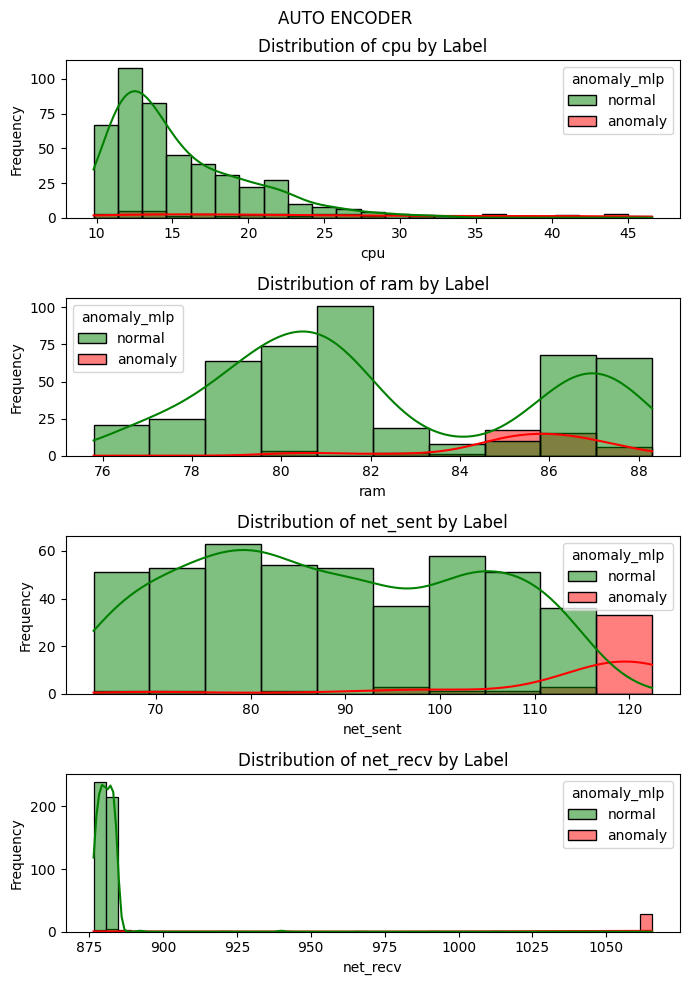

In [17]:
# Visualize the MLP predictions
numerical_cols = X_MLP.select_dtypes(include=np.number).columns
plt.figure(figsize=(7, 10))
for i, col in enumerate(numerical_cols):
  plt.subplot(len(numerical_cols), 1, i + 1)
  sns.histplot(data=X_MLP, x=col, hue='anomaly_mlp', palette={'anomaly': 'red', 'normal': 'green'}, kde=True) # Use hue for coloring by label and palette to set specific colors
  plt.title(f'Distribution of {col} by Label')
  plt.tight_layout()
  plt.xlabel(col)
  plt.suptitle("AUTO ENCODER")
  plt.ylabel('Frequency' if df[col].dtype != 'object' else 'Count')

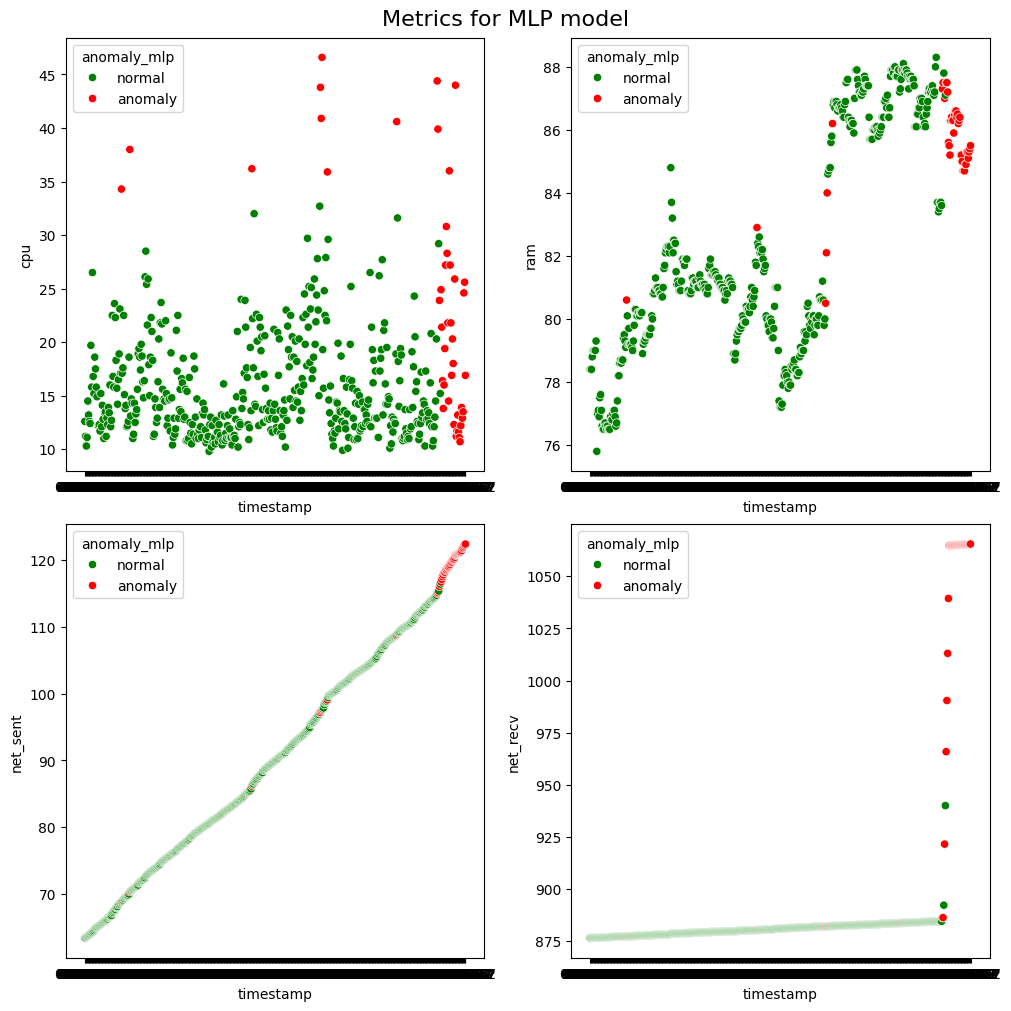

In [18]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig) # Define a 2x2 grid for the current figure
fig.suptitle('Metrics for MLP model', fontsize=16)
ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (2)]
for ax, metric in zip(ax_list, X.columns):
    sns.scatterplot(x=df["timestamp"], y=df[metric], hue=X_MLP["anomaly_mlp"], palette={'anomaly': 'red', 'normal': 'green'}, data=df, ax=ax)
plt.show()

Visualizing metrics for anomaly_ae predictions on Axes(0.125,0.53;0.775x0.35)
Axes(0.125,0.53;0.775x0.35)-->cpu
Axes(0.125,0.53;0.775x0.35)-->ram
Axes(0.125,0.53;0.775x0.35)-->net_sent
Axes(0.125,0.53;0.775x0.35)-->net_recv
Visualizing metrics for anomaly_mlp predictions on Axes(0.125,0.11;0.775x0.35)
Axes(0.125,0.11;0.775x0.35)-->cpu
Axes(0.125,0.11;0.775x0.35)-->ram
Axes(0.125,0.11;0.775x0.35)-->net_sent
Axes(0.125,0.11;0.775x0.35)-->net_recv


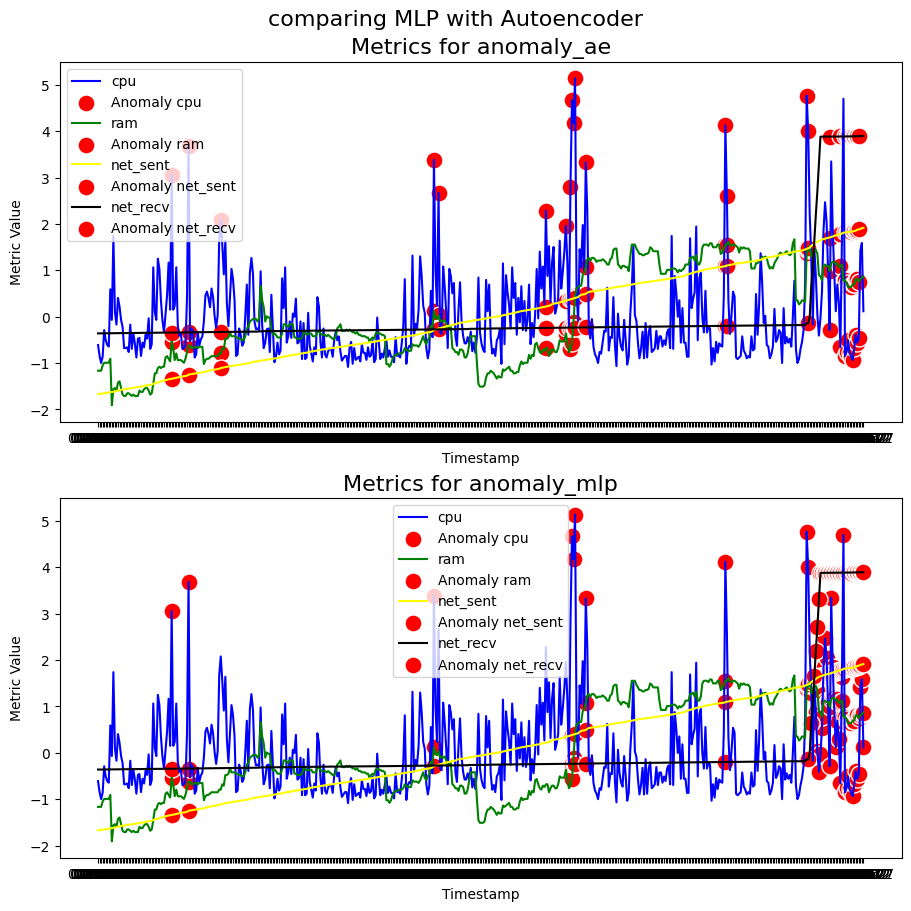

In [19]:
fig = plt.figure(figsize=(9, 9), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig) # Define a 2x2 grid for the current figure
fig.suptitle('comparing MLP with Autoencoder', fontsize=16)
ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (1)]
for model_df, pred_col_name, ax in zip([X_AE, X_MLP], ["anomaly_ae", "anomaly_mlp"], ax_list):
    print(f"Visualizing metrics for {pred_col_name} predictions on {ax}")
    ax.set_title(f'Metrics for {pred_col_name}', fontsize=16)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Metric Value')
    # Plot each metric with its corresponding color
    for color, metric in zip(["blue","green","yellow","black"],X.columns):
        print(f"{ax}-->{metric}")
        df_plot = pd.concat([df["timestamp"],pd.DataFrame(X_scaled, columns=X.columns)],axis=1)
        sns.lineplot(x=df_plot["timestamp"], y=df_plot[metric], color=color, ax=ax, label=f'{metric}')
        sns.scatterplot(x=df_plot["timestamp"], y=df_plot[model_df[pred_col_name] == "anomaly"][metric], color='red', s=150, label=f'Anomaly {metric}', ax=ax)
plt.show()

### JUST trying only on one metric at a time for AUTOENCODER

Processing metric: cpu
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Autoencoder detected 0 anomalies for cpu out of 500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
-------------------normal--------------------
count    500.00000
mean      16.20980
std        5.92014
min        9.80000
25%       12.20000
50%       14.20000
75%       18.60000
max       46.60000
Name: cpu, dtype: float64
-------------------anomaly-------------------
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: cpu, dtype: float64
No anomalies detected for cpu, skipping scatter plot.
Processing metric: ram
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Autoencoder detected 1 anomalies for ram out of 500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
-------------------normal--------------------
count    499.000000
mean      82.485170
std        3.488429
min       76.500000
25%       79.800000
50%       81.200000
75%       86.300000
max       88.300000
Name: ram, dtype: float64
-----

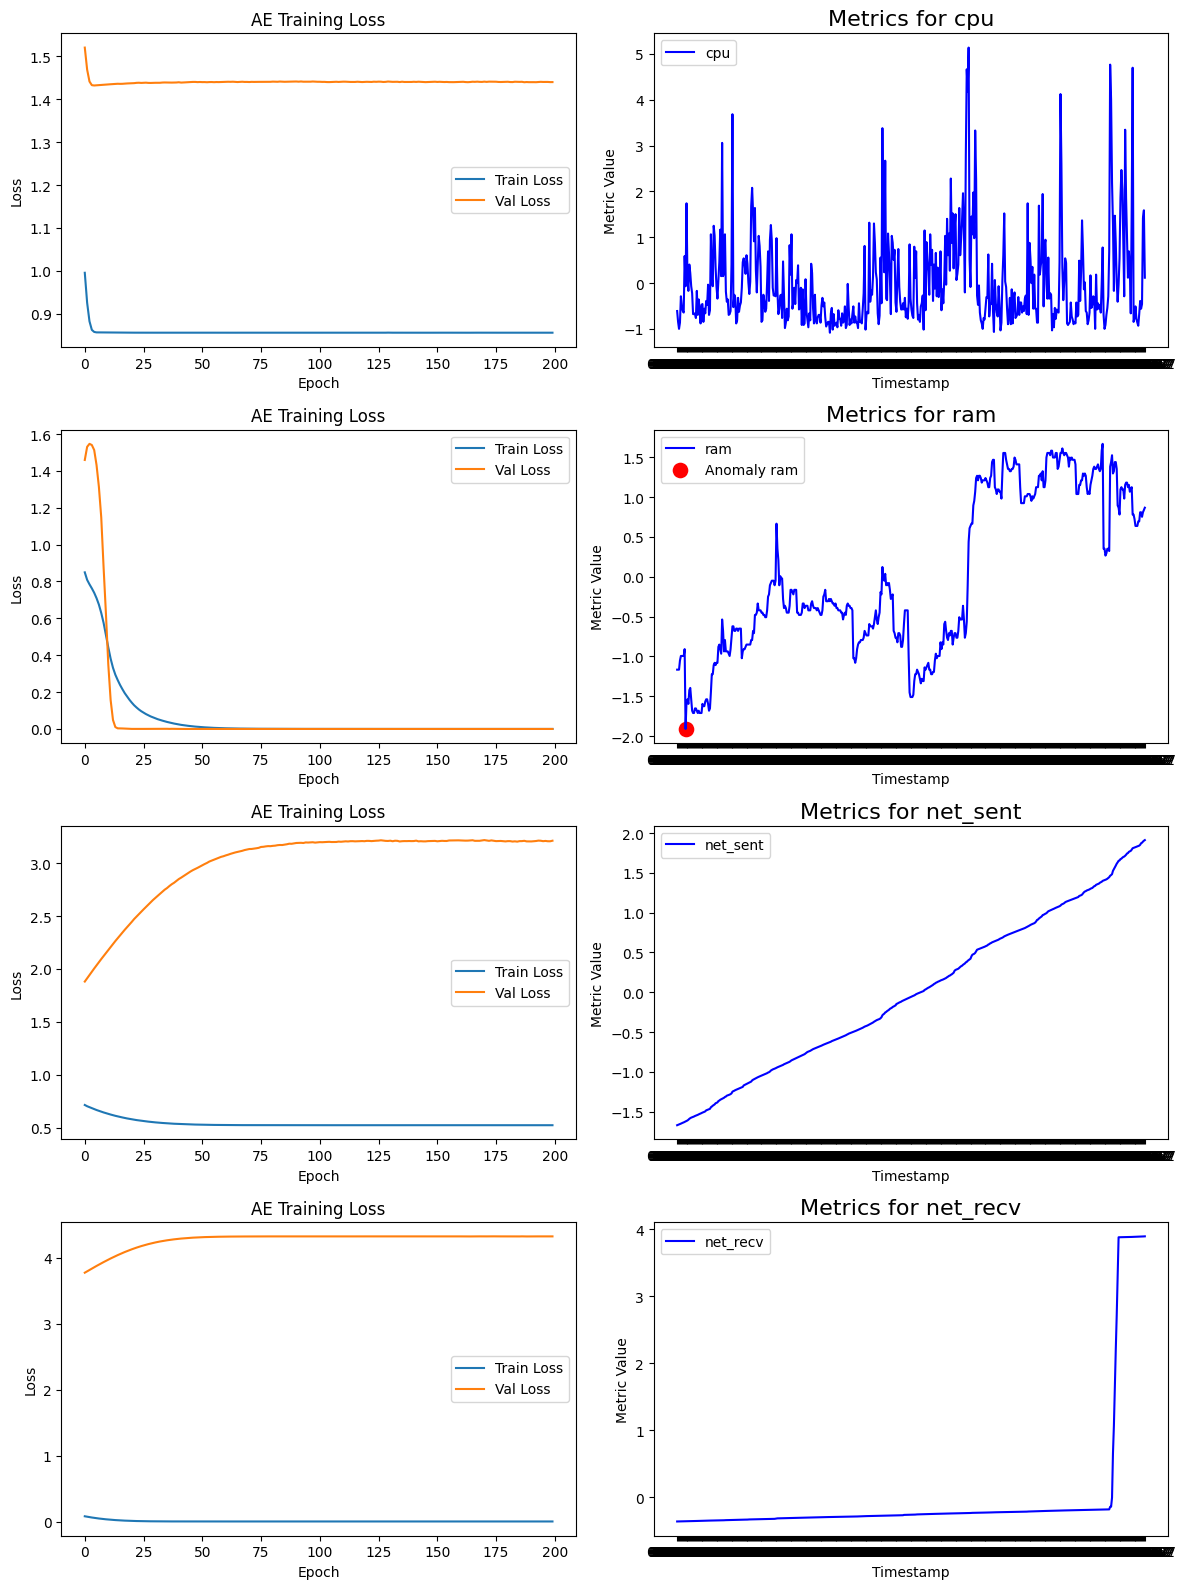

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    mode='auto',          # Direction to monitor (minimize 'val_loss')
    patience=100,         # Number of epochs with no improvement to wait
    verbose=1,            # Verbosity level (prints message when stopping)
    restore_best_weights=True  # Restore the best weights after training
)

fig, ax = plt.subplots(4, 2, figsize=(12, 16))
ax = ax.flatten()
df_plot = pd.concat([df["timestamp"],pd.DataFrame(X_scaled, columns=X.columns)],axis=1)
X_AE_metric = X.copy()

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
X_train = X_scaled.copy()  # Use the scaled data for training the autoencoder
X_test = X_scaled.copy()  # Use the scaled data for testing the autoencoder

#as this is unsupervised learning, we will not use y_train and y_test
training_results_all = {}
for idx, metric in enumerate(X.columns):

    def training_part():
        print(f"Processing metric: {metric}")
        # train the autoencoder on the metric

        input_dim = 1
        input_layer = Input(shape=(input_dim,))

        encoded = Dense(8, activation='relu')(input_layer)
        encoded = Dense(4, activation='relu')(encoded)
        encoded = Dense(2, activation='relu')(encoded)

        decoded = Dense(4, activation='relu')(encoded)
        decoded = Dense(8, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='linear')(decoded)

        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mse')

        history_ae = autoencoder.fit(X_train[:,idx], X_train[:,idx], 
                                    epochs=200, batch_size=32, 
                                    shuffle=True, validation_split=0.25, 
                                    verbose=0)
        
        training_results_all[metric] = {"encoder": autoencoder, "history_ae": history_ae}

    def prediction_part():
        # Reconstruction error
        autoencoder = training_results_all[metric]["encoder"]
        history_ae = training_results_all[metric]["history_ae"]
        y_pred_ae = autoencoder.predict(X_test[:,idx])
        recon_error = np.mean(np.square(X_test[:,idx] - y_pred_ae), axis=1)

        threshold = np.mean(recon_error) + 3*np.std(recon_error)
        threshold = np.percentile(recon_error, 99.5)  # Set threshold at 95th percentile
        y_pred_labels = (recon_error > threshold).astype(int)
        print(f"Autoencoder detected {sum(y_pred_labels)} anomalies for {metric} out of {len(y_pred_labels)}")

        ax_metric = ax[2*idx], ax[2*idx+1]

        sns.lineplot(history_ae.history['loss'], label='Train Loss', ax=ax_metric[0])
        sns.lineplot(history_ae.history['val_loss'], label='Val Loss', ax=ax_metric[0])
        ax_metric[0].set_title('AE Training Loss')
        ax_metric[0].set_xlabel('Epoch')
        ax_metric[0].set_ylabel('Loss')

        X_pred_ae = autoencoder.predict(X_scaled[:,idx])
        recon_error_all = np.mean(np.square(X_scaled[:,idx] - X_pred_ae), axis=1)
        X_AE_metric[f"anomaly_{metric}"] = (recon_error_all > threshold).astype(int)

        X_AE_metric[f"anomaly_{metric}"] = (X_AE_metric[f"anomaly_{metric}"] > 0.5).astype(int)
        # Convert numerical labels to categorical for better readability
        cat_1 = "normal"
        cat_2 = "anomaly"
        name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
        X_AE_metric[f"anomaly_{metric}"] = X_AE_metric[f"anomaly_{metric}"].apply(name_categories)
        X_AE_metric.head()
        # Display the first few rows of the MLP predictions
        print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
        print(X_AE_metric.loc[X_AE_metric[f"anomaly_{metric}"] == cat_1][metric].describe())
        print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
        print(X_AE_metric.loc[X_AE_metric[f"anomaly_{metric}"] == cat_2][metric].describe())

        # sns.scatterplot(x=df["timestamp"], y=df[metric], hue=X_AE_metric[f"anomaly_{metric}"], palette={'anomaly': 'red', 'normal': 'green'}, data=df)
        ax_metric[1].set_title(f'Metrics for {metric}', fontsize=16)
        ax_metric[1].set_xlabel('Timestamp')
        ax_metric[1].set_ylabel('Metric Value')
        sns.lineplot(x=df_plot["timestamp"], y=df_plot[metric], color="blue", ax=ax_metric[1], label=f'{metric}')
        if len(df_plot[X_AE_metric[f"anomaly_{metric}"] == "anomaly"]) > 0:
            sns.scatterplot(x=df_plot["timestamp"], y=df_plot[X_AE_metric[f"anomaly_{metric}"] == "anomaly"][metric], color='red', s=150, label=f'Anomaly {metric}', ax=ax_metric[1])
        else:
            print(f"No anomalies detected for {metric}, skipping scatter plot.")

    training_part()
    prediction_part()

plt.tight_layout()    
plt.show()

Processing metric: cpu
Processing metric: ram
Processing metric: net_sent
Processing metric: net_recv


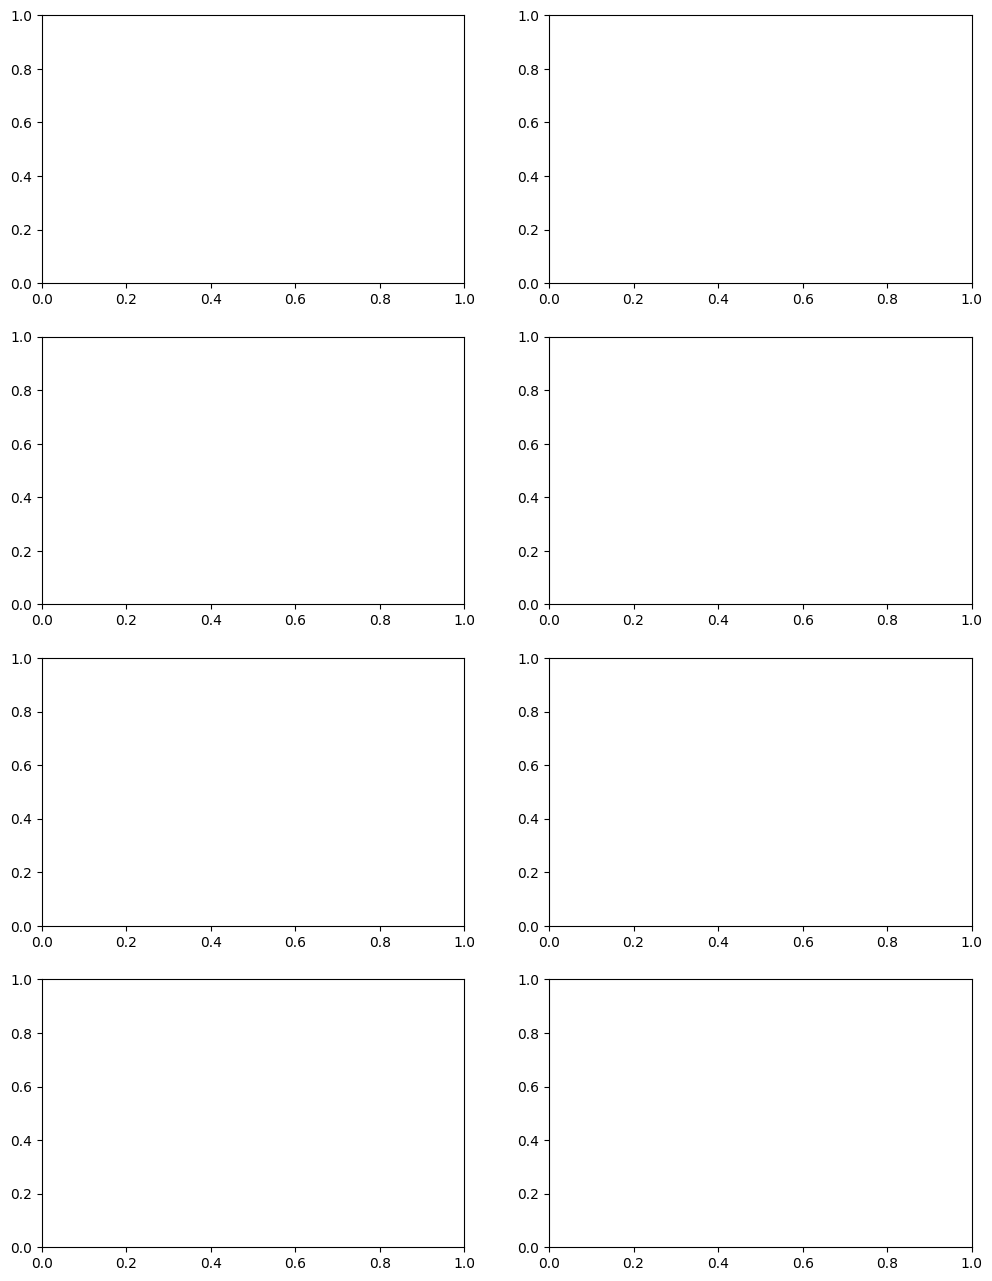

In [24]:
fig, ax = plt.subplots(4, 2, figsize=(12, 16))
ax = ax.flatten()
df_plot = pd.concat([df["timestamp"],pd.DataFrame(X_scaled, columns=X.columns)],axis=1)
X_AE_metric = X.copy()

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
X_train = X_scaled.copy()  # Use the scaled data for training the autoencoder
X_test = X_scaled.copy()  # Use the scaled data for testing the autoencoder

def training_part(idx, metric, epochs=200, batch_size=32):
    print(f"Processing metric: {metric}")
    # train the autoencoder on the metric

    input_dim = 1
    input_layer = Input(shape=(input_dim,))

    encoded = Dense(8, activation='relu')(input_layer)
    encoded = Dense(4, activation='relu')(encoded)
    encoded = Dense(2, activation='relu')(encoded)

    decoded = Dense(4, activation='relu')(encoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    history_ae = autoencoder.fit(X_train[:,idx], X_train[:,idx], 
                                epochs=epochs, batch_size=batch_size, 
                                shuffle=True, validation_split=0.25, 
                                verbose=0)
    
    return {"encoder": autoencoder, "history_ae": history_ae}

def prediction_part(training_results_all, idx, metric, threshold_pct=99, verbose=True):
    # Reconstruction error
    autoencoder = training_results_all[metric]["encoder"]
    history_ae = training_results_all[metric]["history_ae"]
    y_pred_ae = autoencoder.predict(X_test[:,idx])
    recon_error = np.mean(np.square(X_test[:,idx] - y_pred_ae), axis=1)

    # threshold = np.mean(recon_error) + 3*np.std(recon_error)
    threshold = np.percentile(recon_error, threshold_pct)  # Set threshold at 95th percentile
    y_pred_labels = (recon_error > threshold).astype(int)
    print(f"Autoencoder detected {sum(y_pred_labels)} anomalies for {metric} out of {len(y_pred_labels)}")

    ax_metric = ax[2*idx], ax[2*idx+1]

    sns.lineplot(history_ae.history['loss'], label='Train Loss', ax=ax_metric[0])
    sns.lineplot(history_ae.history['val_loss'], label='Val Loss', ax=ax_metric[0])
    ax_metric[0].set_title('AE Training Loss')
    ax_metric[0].set_xlabel('Epoch')
    ax_metric[0].set_ylabel('Loss')

    X_pred_ae = autoencoder.predict(X_scaled[:,idx])
    recon_error_all = np.mean(np.square(X_scaled[:,idx] - X_pred_ae), axis=1)
    X_AE_metric[f"anomaly_{metric}"] = (recon_error_all > threshold).astype(int)

    X_AE_metric[f"anomaly_{metric}"] = (X_AE_metric[f"anomaly_{metric}"] > 0.5).astype(int)
    # Convert numerical labels to categorical for better readability
    cat_1 = "normal"
    cat_2 = "anomaly"
    name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
    X_AE_metric[f"anomaly_{metric}"] = X_AE_metric[f"anomaly_{metric}"].apply(name_categories)
    X_AE_metric.head()

    if verbose:
        # Display the first few rows of the MLP predictions
        print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
        print(X_AE_metric.loc[X_AE_metric[f"anomaly_{metric}"] == cat_1][metric].describe())
        print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
        print(X_AE_metric.loc[X_AE_metric[f"anomaly_{metric}"] == cat_2][metric].describe())

    # sns.scatterplot(x=df["timestamp"], y=df[metric], hue=X_AE_metric[f"anomaly_{metric}"], palette={'anomaly': 'red', 'normal': 'green'}, data=df)
    ax_metric[1].set_title(f'Metrics for {metric}', fontsize=16)
    ax_metric[1].set_xlabel('Timestamp')
    ax_metric[1].set_ylabel('Metric Value')
    sns.lineplot(x=df_plot["timestamp"], y=df_plot[metric], color="blue", ax=ax_metric[1], label=f'{metric}')
    if len(df_plot[X_AE_metric[f"anomaly_{metric}"] == "anomaly"]) > 0:
        sns.scatterplot(x=df_plot["timestamp"], y=df_plot[X_AE_metric[f"anomaly_{metric}"] == "anomaly"][metric], color='red', s=150, label=f'Anomaly {metric}', ax=ax_metric[1])
    else:
        print(f"No anomalies detected for {metric}, skipping scatter plot.")
    
    plt.tight_layout()
    plt.show()


training_results_all = {}
for idx, metric in enumerate(X.columns):
    training_results_all[metric] = training_part(idx, metric, epochs=200, batch_size=32)
    # prediction_part(training_results_all, idx, metric, threshold_pct=99, verbose=True)


ValueError: array length 2000 does not match index length 500

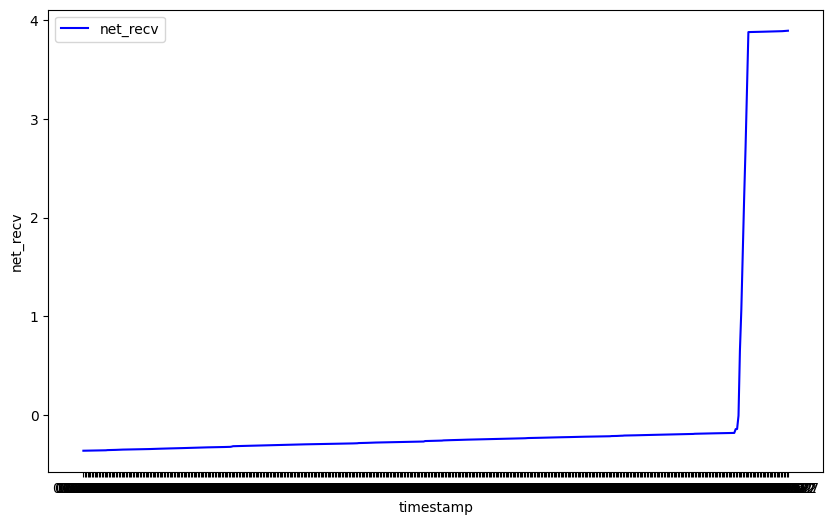

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_plot["timestamp"], y=df_plot[metric], color="blue", label=f'{metric}')
sns.lineplot(x=df_plot["timestamp"], y=y_pred_ae.ravel(), color="yellow", label='net_recv')
plt.show()
